In [101]:
# CONFIG_PATH = "configs/tmp.yml"
CONFIG_PATH = "configs/debug_med_ID_sim_new_votes.yml"
# CONFIG_PATH = "configs/debug_med_ID_sim_new_votes_finetune.yml"


In [102]:
from collections import Counter, defaultdict
import os
import random
import shutil
import numpy as np
import pandas as pd
from superdebug import debug
import torch
from data import get_model_input
from utils import get_config, join_sets, load_model, print_log, save_model, load_model_dict
from model import get_best_model

In [103]:
config = get_config(CONFIG_PATH, "_curation")
use_voted_users_feature = config["use_voted_users_feature"]
if use_voted_users_feature:
    debug("Use peer votes as model input feature")
else:
    debug("Finetune the model using peer votes")

GPU ready...
Smart using cuda:1
------------------ 2022-07-25 19:12:05 ------------------
DEBUG: at <ipython-input-103-1fd0ad4c56ed>:4 <module>
Use peer votes as model input feature
------------------ 2022-07-25 19:12:05 ------------------


In [104]:
all_feature_columns, target, train_model_input, test_model_input, feature_names, original_feature_map, max_voted_users, train_data, test_data, test_data_info = get_model_input(config)
model, user_embedding = get_best_model(config, all_feature_columns, feature_names)
debug(max_voted_users=max_voted_users)

------------------ 2022-07-25 19:12:05 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/data.py:228 get_model_input
Loading prepared data...
------------------ 2022-07-25 19:12:05 ------------------
------------------ 2022-07-25 19:12:18 ------------------
DEBUG: 1 vars: ['max_voted_users'], at <ipython-input-104-89a97e373390>:3 <module>
0 / 5.  max_voted_users num val: 808
------------------ 2022-07-25 19:12:18 ------------------


In [105]:
model.device
!nvidia-smi

Mon Jul 25 19:12:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.64       Driver Version: 430.64       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000001:00:00.0 Off |                    0 |
| N/A   35C    P0    36W / 250W |   7895MiB / 16160MiB |     34%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  Off  | 00000002:00:00.0 Off |                    0 |
| N/A   33C    P0    36W / 250W |   4389MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [106]:
for column in ["input_ids", "token_type_ids", "attention_mask"]:
    if column in test_model_input:
        test_data[column] = test_model_input[column]
test_data.iloc[:2]


,SUBMISSION_ID,SUBREDDIT,CREATED_TIME,USERNAME,VOTE,TITLE,AUTHOR,#_COMMENTS,NSFW,SCORE,UPVOTED_%,LINK,UPVOTED_USERS,DOWNVOTED_USERS
1,460,70,0.990180,14636,1,This is Narwhal. He has a tail growing out of ...,199,2381,0.0,119078,0.9,https://www.reddit.com/r/aww/comments/dvjjn9/t...,[],[]
2,924,123,0.992139,9347,0,The President of the United States has been Im...,298,5575,0.0,57208,0.7,https://www.reddit.com/r/pics/comments/ecm3wx/...,[],[]


In [107]:
from train import evaluate_model, train_model
import copy

def count_new_vote_pred(peer_votes_num_acc_df, target_vote, pred_target_vote_score, peer_vote_num, peer_votes_data):
    peer_votes_num_acc_df.loc[peer_vote_num, "Total"] += 1
    pred_target_vote = int(pred_target_vote_score >= 0.5)
    if pred_target_vote == target_vote:
        peer_votes_num_acc_df.loc[peer_vote_num, "Acc"] += 1
    if peer_vote_num > 0:
        majority_vote = -1
        if sum(peer_votes_data["VOTE"][:peer_vote_num])/peer_vote_num > 0.5:
            majority_vote = 1
        elif sum(peer_votes_data["VOTE"][:peer_vote_num])/peer_vote_num < 0.5:
            majority_vote = 0
        if pred_target_vote == majority_vote:
            peer_votes_num_acc_df.loc[peer_vote_num, "Same as majority"] += 1


def pred_acc_peer_feature(peer_votes_num_acc_df, target_vote, target_vote_data, peer_votes_data):
    all_peer_users = peer_votes_data["USERNAME"].to_numpy()
    all_peer_votes = peer_votes_data["VOTE"].to_numpy()
    target_vote_model_input = {column: target_vote_data[column] for column in target_vote_data}
    upvoted_users, downvoted_users = [], []
    for new_user_i in range(-1, len(all_peer_users)):
        peer_vote_num = new_user_i + 1
        if new_user_i >= 0:
            new_user = all_peer_users[new_user_i]
            new_vote = all_peer_votes[new_user_i]
            if new_vote == 1:
                upvoted_users.append(int(new_user))
            elif new_vote == 0:
                downvoted_users.append(int(new_user))
        target_vote_model_input["UPVOTED_USERS"] = [upvoted_users]
        target_vote_model_input["DOWNVOTED_USERS"] = [downvoted_users]
        pred_target_vote_score = evaluate_model(model, target_vote_model_input, target_vote_model_input.get("input_ids", None), target_vote_model_input.get("token_type_ids", None), target_vote_model_input.get("attention_mask", None), target_vote_data[target].values, data = target_vote_data, weights = None, batch_size=1, max_voted_users=max_voted_users,sample_voted_users=False, return_prediction=True, disable_tqdm=True)[0,0]
        count_new_vote_pred(peer_votes_num_acc_df, target_vote, pred_target_vote_score, peer_vote_num, peer_votes_data)

def pred_acc_peer_finetune(peer_votes_num_acc_df, target_vote, target_vote_data, peer_votes_data, n_step_per_sample=1):
    target_vote_model_input = {column: target_vote_data[column] for column in target_vote_data}
    tmp_model = copy.deepcopy(model)
    # 0 peer votes
    pred_target_vote_score = evaluate_model(tmp_model, target_vote_model_input, target_vote_model_input.get("input_ids", None), target_vote_model_input.get("token_type_ids", None), target_vote_model_input.get("attention_mask", None), target_vote_data[target].values, data = target_vote_data, weights = None, batch_size=1, max_voted_users=max_voted_users,sample_voted_users=False, return_prediction=True, disable_tqdm=True)[0,0]
    count_new_vote_pred(peer_votes_num_acc_df, target_vote, pred_target_vote_score, 0, peer_votes_data)

    if len(peer_votes_data) > 0:
        peer_votes_model_input = {column: peer_votes_data[column] for column in peer_votes_data}
        for new_user_i, tmp_model in enumerate(train_model(config, tmp_model, x=peer_votes_model_input, y=peer_votes_data[target].values, weights = None, batch_size=1, epochs=1, verbose=2, validation_split=False, max_voted_users=max_voted_users, step_generator=True, n_step_per_sample=n_step_per_sample)):
            if tmp_model is None:
                break
            peer_vote_num = new_user_i + 1
            pred_target_vote_score = evaluate_model(tmp_model, target_vote_model_input, target_vote_model_input.get("input_ids", None), target_vote_model_input.get("token_type_ids", None), target_vote_model_input.get("attention_mask", None), target_vote_data[target].values, data = target_vote_data, weights = None, batch_size=1, max_voted_users=max_voted_users,sample_voted_users=False, return_prediction=True, disable_tqdm=True)[0,0]
            count_new_vote_pred(peer_votes_num_acc_df, target_vote, pred_target_vote_score, peer_vote_num, peer_votes_data)

def pred_acc_peer_feature_finetune(peer_votes_num_acc_df, target_vote, target_vote_data, peer_votes_data, n_step_per_sample=1): # conbination of the upper two
    pd.options.mode.chained_assignment = None
    all_peer_users = peer_votes_data["USERNAME"].to_numpy()
    all_peer_votes = peer_votes_data["VOTE"].to_numpy()
    target_vote_model_input = {column: target_vote_data[column] for column in target_vote_data}

    tmp_model = copy.deepcopy(model)
    # 0 peer votes
    upvoted_users, downvoted_users = [], []
    target_vote_model_input["UPVOTED_USERS"] = [upvoted_users]
    target_vote_model_input["DOWNVOTED_USERS"] = [downvoted_users]
    pred_target_vote_score = evaluate_model(tmp_model, target_vote_model_input, target_vote_model_input.get("input_ids", None), target_vote_model_input.get("token_type_ids", None), target_vote_model_input.get("attention_mask", None), target_vote_data[target].values, data = target_vote_data, weights = None, batch_size=1, max_voted_users=max_voted_users,sample_voted_users=False, return_prediction=True, disable_tqdm=True)[0,0]
    count_new_vote_pred(peer_votes_num_acc_df, target_vote, pred_target_vote_score, 0, peer_votes_data)

    if len(peer_votes_data) > 0:
        peer_votes_model_input = {column: peer_votes_data[column] for column in peer_votes_data}
        # construct train model peer_votes_model_input
        peer_votes_model_input["UPVOTED_USERS"].loc[0] = upvoted_users
        peer_votes_model_input["DOWNVOTED_USERS"].loc[0] = downvoted_users
        for user_i in range(1, len(all_peer_users)):
            new_user = all_peer_users[user_i - 1] # add last user (user_i - 1) to the peer votes for user_i
            new_vote = all_peer_votes[user_i - 1]
            if new_vote == 1:
                upvoted_users.append(int(new_user))
            elif new_vote == 0:
                downvoted_users.append(int(new_user))
            peer_votes_model_input["UPVOTED_USERS"].loc[user_i] = upvoted_users
            peer_votes_model_input["DOWNVOTED_USERS"].loc[user_i] = downvoted_users
        
        # finetune the model
        upvoted_users, downvoted_users = [], []
        for new_user_i, tmp_model in enumerate(train_model(config, tmp_model, x=peer_votes_model_input, y=peer_votes_data[target].values, weights = None, batch_size=1, epochs=1, verbose=2, validation_split=False, max_voted_users=max_voted_users, step_generator=True, n_step_per_sample=n_step_per_sample)):
            if tmp_model is None:
                break
            peer_vote_num = new_user_i + 1

            # add peer votes to model input features
            new_user = all_peer_users[new_user_i]
            new_vote = all_peer_votes[new_user_i]
            if new_vote == 1:
                upvoted_users.append(int(new_user))
            elif new_vote == 0:
                downvoted_users.append(int(new_user))
            target_vote_model_input["UPVOTED_USERS"] = [upvoted_users]
            target_vote_model_input["DOWNVOTED_USERS"] = [downvoted_users]

            pred_target_vote_score = evaluate_model(tmp_model, target_vote_model_input, target_vote_model_input.get("input_ids", None), target_vote_model_input.get("token_type_ids", None), target_vote_model_input.get("attention_mask", None), target_vote_data[target].values, data = target_vote_data, weights = None, batch_size=1, max_voted_users=max_voted_users,sample_voted_users=False, return_prediction=True, disable_tqdm=True)[0,0]
            count_new_vote_pred(peer_votes_num_acc_df, target_vote, pred_target_vote_score, peer_vote_num, peer_votes_data)

In [108]:
if not use_voted_users_feature:
    # model.optim = torch.optim.Adam(model.parameters(), lr = 1 * config["learning_rate"]) # 2 还不错，5不行
    n_step_per_sample = 4

In [110]:
from tqdm import tqdm

test_submissions = list(set(test_data["SUBMISSION_ID"]))
peer_votes_num_acc_df = pd.DataFrame(np.zeros((max_voted_users + 1,3)), columns=['Acc', 'Total', "Same as majority"])

for submission_id in tqdm(test_submissions[:500]):
    submission_votes_data = test_data[test_data["SUBMISSION_ID"] == submission_id]
    submission_votes_data = submission_votes_data.sample(frac=1).reset_index(drop=True) # shuffle
    last_vote_series = submission_votes_data.iloc[-1]
    target_vote = last_vote_series["VOTE"]
    target_vote_data = pd.DataFrame([last_vote_series])
    peer_votes_data = submission_votes_data.iloc[:-1]
    if use_voted_users_feature:
        pred_acc_peer_feature(peer_votes_num_acc_df, target_vote, target_vote_data, peer_votes_data)
        # pred_acc_peer_feature_finetune(peer_votes_num_acc_df, target_vote, target_vote_data, peer_votes_data, n_step_per_sample=n_step_per_sample)
    else:
        pred_acc_peer_finetune(peer_votes_num_acc_df, target_vote, target_vote_data, peer_votes_data, n_step_per_sample=n_step_per_sample)        



 64%|██████▍   | 218/338 [08:59<05:45,  2.88s/it]

In [ ]:
peer_votes_num_acc_df = peer_votes_num_acc_df[peer_votes_num_acc_df["Total"] > 0]
peer_votes_num_acc_df["Acc rate"] = peer_votes_num_acc_df["Acc"]/peer_votes_num_acc_df["Total"]
peer_votes_num_acc_df["Same as majority rate"] = peer_votes_num_acc_df["Same as majority"]/peer_votes_num_acc_df["Total"]
peer_votes_num_acc_df["Total scaled"] = peer_votes_num_acc_df["Total"]/max(peer_votes_num_acc_df["Total"])
peer_votes_num_acc_df

,Acc,Total,Same as majority,Acc rate,Same as majority rate,Total scaled
0,337.0,500.0,0.0,0.674000,0.000000,1.000
1,75.0,103.0,65.0,0.728155,0.631068,0.206
2,39.0,57.0,23.0,0.684211,0.403509,0.114
3,23.0,34.0,24.0,0.676471,0.705882,0.068
4,18.0,27.0,15.0,0.666667,0.555556,0.054
...,...,...,...,...,...,...
62,1.0,1.0,1.0,1.000000,1.000000,0.002
63,1.0,1.0,1.0,1.000000,1.000000,0.002
64,1.0,1.0,1.0,1.000000,1.000000,0.002
65,1.0,1.0,1.0,1.000000,1.000000,0.002


------------------ 2022-07-25 19:07:06 ------------------
DEBUG: at <ipython-input-99-73667efd2700>:6 <module>
Acc rate
------------------ 2022-07-25 19:07:06 ------------------


<AxesSubplot:ylabel='Acc rate'>

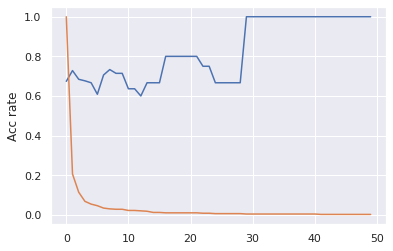

In [ ]:
def convert_df_to_dict(df: pd.DataFrame):
    return {x:list(df[x]) for x in df}
import seaborn as sns

peer_votes_num_acc_df_part = peer_votes_num_acc_df.iloc[:50]
debug("Acc rate")
sns.set_theme()
sns.lineplot(data=peer_votes_num_acc_df_part, x=peer_votes_num_acc_df_part.index, y='Acc rate')
sns.lineplot(data=peer_votes_num_acc_df_part, x=peer_votes_num_acc_df_part.index, y='Total scaled')
# ax.set_ylim(ymax=1)

------------------ 2022-07-25 19:07:07 ------------------
DEBUG: at <ipython-input-100-256f6a6658fb>:1 <module>
Same as majority rate
------------------ 2022-07-25 19:07:07 ------------------


<AxesSubplot:ylabel='Same as majority rate'>

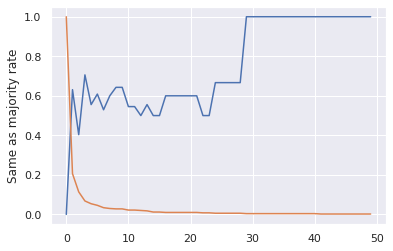

In [ ]:
debug("Same as majority rate")
sns.lineplot(data=peer_votes_num_acc_df_part, x=peer_votes_num_acc_df_part.index, y='Same as majority rate')
sns.lineplot(data=peer_votes_num_acc_df_part, x=peer_votes_num_acc_df_part.index, y='Total scaled')
